<a href="https://colab.research.google.com/github/jaydent22/661-assignment-1/blob/main/hw2/661_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a recurrent neural network for sentiment analysis

This assignment involves training a recurrent neural network to classify reviews as positive or negative.



## Setup

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocessing

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
print(train_df.shape)
print(train_df.head())

(25000, 2)
                                              review sentiment
0  For a movie that gets no respect there sure ar...       pos
1  Bizarre horror movie filled with famous faces ...       pos
2  A solid, if unremarkable film. Matthau, as Ein...       pos
3  It's a strange feeling to sit alone in a theat...       pos
4  You probably all already know this by now, but...       pos


In [ ]:
print(train_df.describe())

                                                   review sentiment
count                                               25000     25000
unique                                              24904         2
top     When i got this movie free from my job, along ...       pos
freq                                                    3     12500


In [ ]:
for index, row in train_df.iterrows():
  if row['sentiment'] == 'pos':
    train_df.at[index, 'sentiment'] = 1
  else:
    train_df.at[index, 'sentiment'] = 0

In [ ]:
print(train_df.sentiment.value_counts())

sentiment
1    12500
0    12500
Name: count, dtype: int64


In [ ]:
for index, row in test_df.iterrows():
  if row['sentiment'] == 'pos':
    test_df.at[index, 'sentiment'] = 1
  else:
    test_df.at[index, 'sentiment'] = 0

In [ ]:
print(train_df.sentiment.value_counts())

sentiment
1    12500
0    12500
Name: count, dtype: int64


### Data cleaning

In [ ]:
print(train_df.review.iloc[0])

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.


In [ ]:
for index, row in train_df.iterrows():
  text = row.review
  tokens = word_tokenize(text)
  # convert to lowercase
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  train_df.at[index, 'review'] = words

In [ ]:
print(train_df.head(5))

                                              review sentiment
0  [movie, gets, respect, sure, lot, memorable, q...         1
1  [bizarre, horror, movie, filled, famous, faces...         1
2  [solid, unremarkable, film, matthau, einstein,...         1
3  [strange, feeling, sit, alone, theater, occupi...         1
4  [probably, already, know, additional, episodes...         1


In [ ]:
print(train_df.review.iloc[0])

['movie', 'gets', 'respect', 'sure', 'lot', 'memorable', 'quotes', 'listed', 'gem', 'imagine', 'movie', 'joe', 'piscopo', 'actually', 'funny', 'maureen', 'stapleton', 'scene', 'stealer', 'moroni', 'character', 'absolute', 'scream', 'watch', 'alan', 'skipper', 'hale', 'jr', 'police', 'sgt']


In [ ]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
for index, row in train_df.iterrows():
  text = row.review
  stemmed = [porter.stem(word) for word in text]
  train_df.at[index, 'review'] = stemmed

In [ ]:
print(train_df.review.iloc[0])

['movi', 'get', 'respect', 'sure', 'lot', 'memor', 'quot', 'list', 'gem', 'imagin', 'movi', 'joe', 'piscopo', 'actual', 'funni', 'maureen', 'stapleton', 'scene', 'stealer', 'moroni', 'charact', 'absolut', 'scream', 'watch', 'alan', 'skipper', 'hale', 'jr', 'polic', 'sgt']


In [ ]:
print(test_df.review.iloc[0])

Based on an actual story, John Boorman shows the struggle of an American doctor, whose husband and son were murdered and she was continually plagued with her loss. A holiday to Burma with her sister seemed like a good idea to get away from it all, but when her passport was stolen in Rangoon, she could not leave the country with her sister, and was forced to stay back until she could get I.D. papers from the American embassy. To fill in a day before she could fly out, she took a trip into the countryside with a tour guide. "I tried finding something in those stone statues, but nothing stirred in me. I was stone myself." <br /><br />Suddenly all hell broke loose and she was caught in a political revolt. Just when it looked like she had escaped and safely boarded a train, she saw her tour guide get beaten and shot. In a split second she decided to jump from the moving train and try to rescue him, with no thought of herself. Continually her life was in danger. <br /><br />Here is a woman w

In [ ]:
for index, row in test_df.iterrows():
  text = row.review
  tokens = word_tokenize(text)
  # convert to lowercase
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  # stem words
  stemmed = [porter.stem(word) for word in words]
  test_df.at[index, 'review'] = stemmed

In [ ]:
print(test_df.review.iloc[0])

['base', 'actual', 'stori', 'john', 'boorman', 'show', 'struggl', 'american', 'doctor', 'whose', 'husband', 'son', 'murder', 'continu', 'plagu', 'loss', 'holiday', 'burma', 'sister', 'seem', 'like', 'good', 'idea', 'get', 'away', 'passport', 'stolen', 'rangoon', 'could', 'leav', 'countri', 'sister', 'forc', 'stay', 'back', 'could', 'get', 'id', 'paper', 'american', 'embassi', 'fill', 'day', 'could', 'fli', 'took', 'trip', 'countrysid', 'tour', 'guid', 'tri', 'find', 'someth', 'stone', 'statu', 'noth', 'stir', 'stone', 'br', 'br', 'suddenli', 'hell', 'broke', 'loos', 'caught', 'polit', 'revolt', 'look', 'like', 'escap', 'safe', 'board', 'train', 'saw', 'tour', 'guid', 'get', 'beaten', 'shot', 'split', 'second', 'decid', 'jump', 'move', 'train', 'tri', 'rescu', 'thought', 'continu', 'life', 'danger', 'br', 'br', 'woman', 'demonstr', 'spontan', 'selfless', 'chariti', 'risk', 'life', 'save', 'anoth', 'patricia', 'arquett', 'beauti', 'look', 'beauti', 'heart', 'unforgett', 'stori', 'br', 'b

### Train set analysis

In [ ]:
longest_index = 0
longest_review = train_df.review.iloc[0]
for index, row in train_df.iterrows():
  if len(row.review) > len(longest_review):
    longest_index = index
    longest_review = row.review
print(longest_index)
print(longest_review)
print(len(longest_review))

1846
['match', 'tag', 'team', 'tabl', 'match', 'bubba', 'ray', 'spike', 'dudley', 'vs', 'eddi', 'guerrero', 'chri', 'benoit', 'bubba', 'ray', 'spike', 'dudley', 'start', 'thing', 'tag', 'team', 'tabl', 'match', 'eddi', 'guerrero', 'chri', 'benoit', 'accord', 'rule', 'match', 'oppon', 'go', 'tabl', 'order', 'get', 'win', 'benoit', 'guerrero', 'heat', 'earli', 'take', 'turn', 'hammer', 'first', 'spike', 'bubba', 'ray', 'german', 'suplex', 'benoit', 'bubba', 'took', 'wind', 'dudley', 'brother', 'spike', 'tri', 'help', 'brother', 'refere', 'restrain', 'benoit', 'guerrero', 'gang', 'corner', 'benoit', 'stomp', 'away', 'bubba', 'guerrero', 'set', 'tabl', 'outsid', 'spike', 'dash', 'ring', 'somersault', 'top', 'rope', 'onto', 'guerrero', 'outsid', 'recov', 'take', 'care', 'spike', 'guerrero', 'slip', 'tabl', 'ring', 'help', 'wolverin', 'set', 'tandem', 'set', 'doubl', 'superplex', 'middl', 'rope', 'would', 'put', 'bubba', 'tabl', 'spike', 'knock', 'tabl', 'right', 'brother', 'came', 'crash', 

In [ ]:
print(len(set(train_df.review.iloc[1846])))

514


In [ ]:
unique_words = set()
for index,row in train_df.head(2500).iterrows():
  for word in row.review:
    unique_words.add(word)
print(len(unique_words))

21762


First 10 reviews have 628 unique words

### Convert to arrays

In [ ]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df.review)
print(*list(tokenizer.word_index.items())[:10])

('br', 1) ('movi', 2) ('film', 3) ('nt', 4) ('one', 5) ('like', 6) ('time', 7) ('good', 8) ('make', 9) ('get', 10)


In [ ]:
X_train_tokens = tokenizer.texts_to_sequences(train_df.review)
X_test_tokens = tokenizer.texts_to_sequences(test_df.review)
seq_lengths = np.array([len(x) for x in X_train_tokens])
print(seq_lengths.max())

1430


In [ ]:
# assuming 95% of sequence lengths lie between 2 stdevs of mean
upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
upper_bound

306

In [ ]:
X_train = pad_sequences(X_train_tokens, maxlen=upper_bound)
X_test = pad_sequences(X_test_tokens, maxlen=upper_bound)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(25000, 306)
(25000, 306)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 

In [ ]:
y_train = train_df.sentiment.to_numpy()
y_test = test_df.sentiment.to_numpy()

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
print(X_train)
print(X_val)
print(X_test)

[[0.0000e+00 0.0000e+00 0.0000e+00 ... 1.5370e+03 4.8100e+02 5.3310e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 6.5410e+03 2.3000e+01 9.3900e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 3.8850e+03 4.6390e+03 1.1197e+04]
 ...
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 1.0000e+00 1.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 2.8890e+03 2.7500e+03 1.4060e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 6.4750e+03 6.0670e+03 2.2700e+02]]
[[0.0000e+00 0.0000e+00 0.0000e+00 ... 4.4600e+02 1.2860e+03 8.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 8.2640e+03 9.0000e+01 5.1000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 5.5000e+01 2.4400e+02 4.7300e+02]
 ...
 [2.0634e+04 1.5780e+03 1.3800e+02 ... 2.7330e+03 2.2590e+04 1.9000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 9.6800e+02 8.8000e+02 2.5700e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 4.4120e+03 2.0000e+00 1.1160e+03]]
[[0.000e+00 0.000e+00 0.000e+00 ... 1.958e+03 7.000e+03 2.327e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 2.000e+01

In [ ]:
print(y_train)
print(y_val)
print(y_test)

[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 1. 0. 0.]
[1. 0. 1. ... 1. 0. 0.]


## Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_shape=(X_train.shape[1],)))
model.add(LSTM(units=16, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 306, 128)            │       4,480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,489,297 (17.13 MB)

 Trainable params: 4,489,297 (17.13 MB)

 Non-trainable params: 0 (0.00 B)

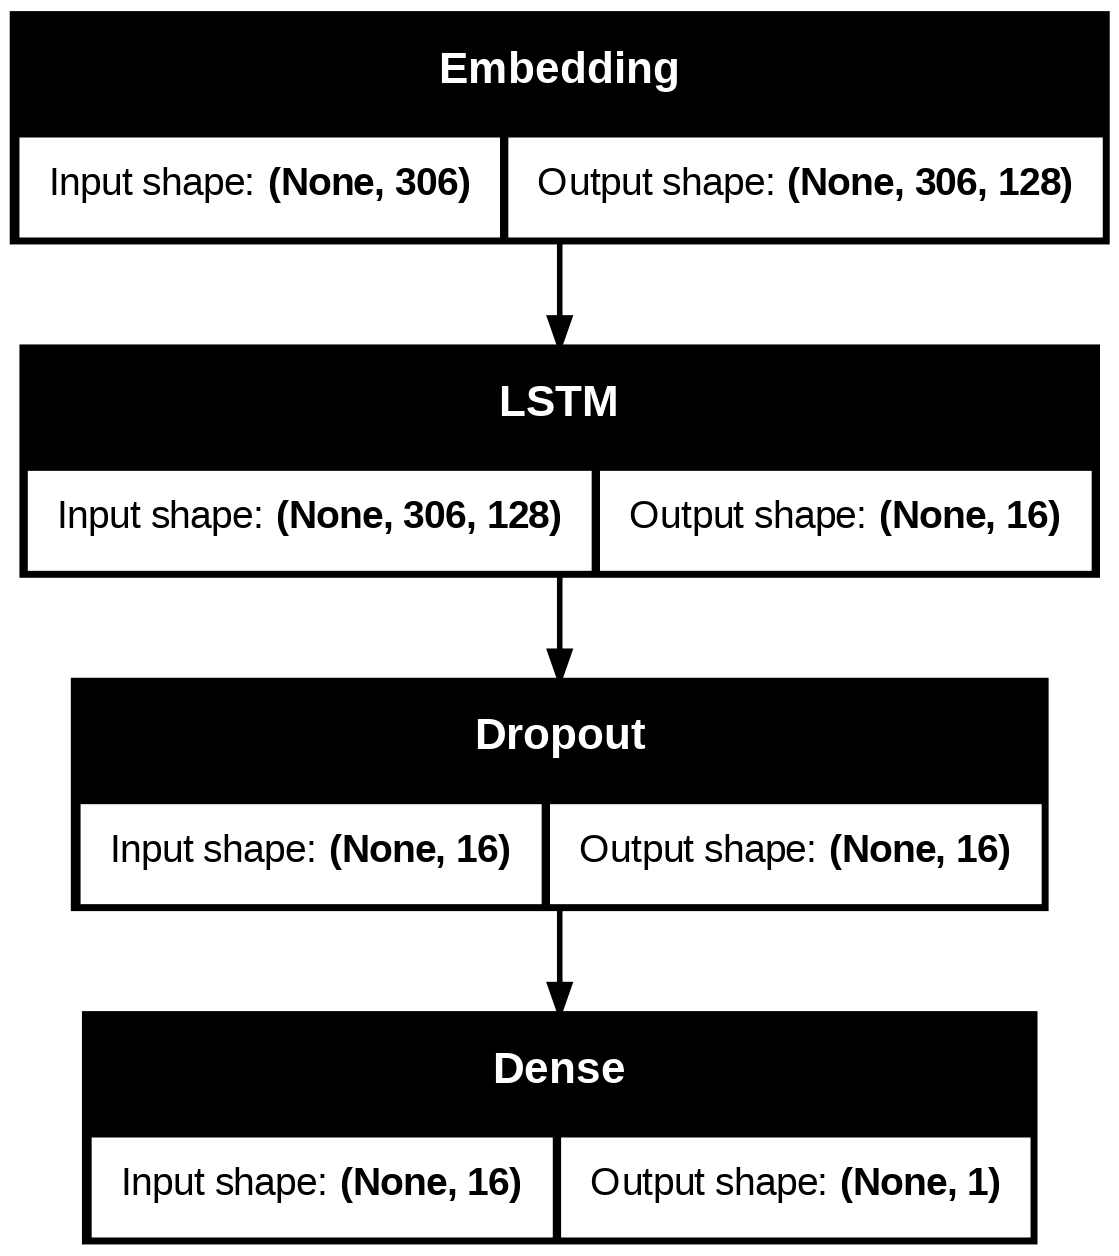

In [ ]:
plot_model(model, show_shapes=True)

## Training

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=384, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 401ms/step - accuracy: 0.5142 - loss: 0.6927 - val_accuracy: 0.6043 - val_loss: 0.6904
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - accuracy: 0.5906 - loss: 0.6891 - val_accuracy: 0.6579 - val_loss: 0.6863
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.6495 - loss: 0.6839 - val_accuracy: 0.6941 - val_loss: 0.6783
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.7043 - loss: 0.6724 - val_accuracy: 0.7309 - val_loss: 0.6588
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.7569 - loss: 0.6412 - val_accuracy: 0.7869 - val_loss: 0.5916
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step - accuracy: 0.8123 - loss: 0.5471 - val_accuracy: 0.8465 - val_loss: 0.4588
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 392ms/step - accuracy: 0.8448 - loss: 0.4557 - val_accuracy: 0.8544 - val_loss: 0.4020
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.8603 - loss: 0.4131 - val_accu

Text(0.5, 0, 'epoch')

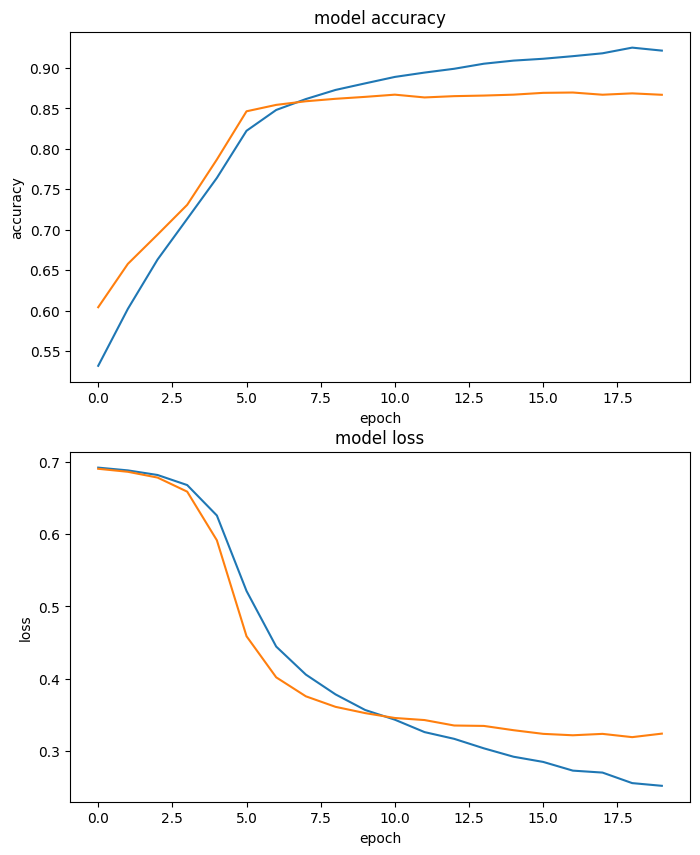

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(8,10))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')

## Evaluation

In [ ]:
acc = model.evaluate(X_test, y_test)
print("Accuracy: ", acc[1])

391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.8605 - loss: 0.3343
Accuracy:  0.8613600134849548


In [ ]:
pred = model.predict(X_test)
pred = pred.round()
print(classification_report(y_test, pred))

391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      6192
         1.0       0.85      0.87      0.86      6308

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



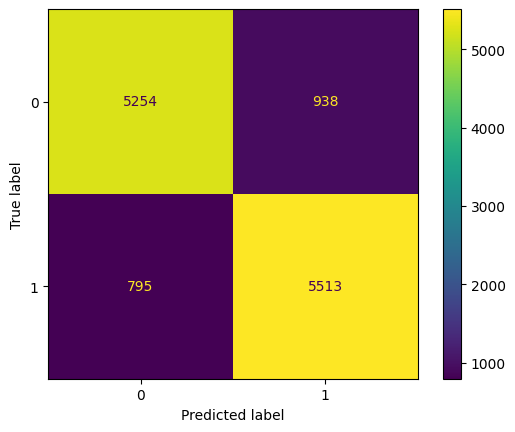

In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.8612418871733364


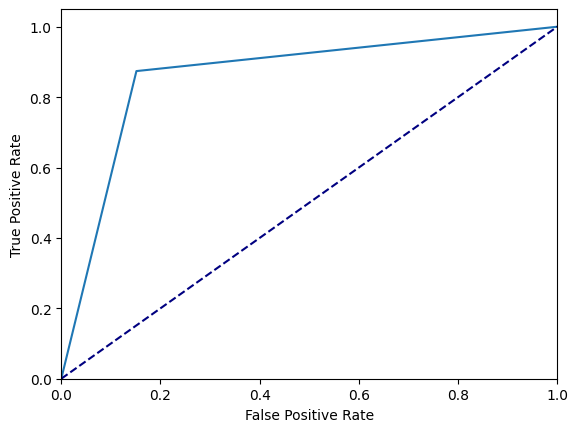

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
print(auc(fpr, tpr))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
print("Overall metrics:\n")
print("Accuracy: %.2f" % (acc[1]))
print("Precision: %.2f" % (precision_score(y_test, pred)))
print("Recall: %.2f" % (recall_score(y_test, pred)))
print("F1 score: %.2f" % (f1_score(y_test, pred)))

Overall metrics:

Accuracy: 0.86
Precision: 0.85
Recall: 0.87
F1 score: 0.86


## Ablation study

### Remove all dropout

In [ ]:
ab_model = Sequential()
ab_model.add(Embedding(input_dim=max_words, output_dim=128, input_shape=(X_train.shape[1],)))
ab_model.add(LSTM(units=16))
ab_model.add(Dense(1, activation='sigmoid'))
ab_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 306, 128)            │       4,480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,489,297 (17.13 MB)

 Trainable params: 4,489,297 (17.13 MB)

 Non-trainable params: 0 (0.00 B)

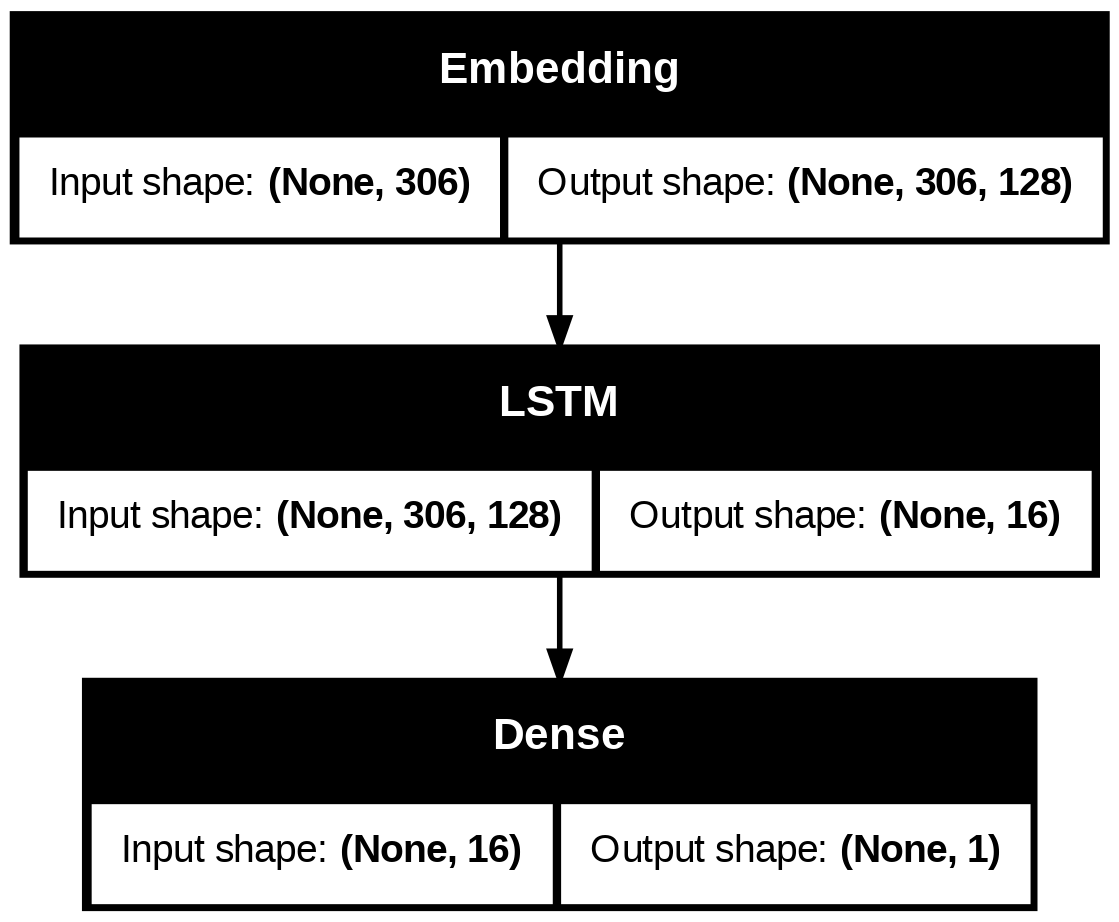

In [ ]:
plot_model(ab_model, show_shapes=True)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)
ab_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = ab_model.fit(X_train, y_train, epochs=20, batch_size=384, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5622 - loss: 0.6920 - val_accuracy: 0.6717 - val_loss: 0.6875
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7103 - loss: 0.6843 - val_accuracy: 0.7322 - val_loss: 0.6741
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7630 - loss: 0.6646 - val_accuracy: 0.7772 - val_loss: 0.6276
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8087 - loss: 0.5904 - val_accuracy: 0.8426 - val_loss: 0.4817
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8647 - loss: 0.4471 - val_accuracy: 0.8476 - val_loss: 0.4338
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8836 - loss: 0.3913 - val_accuracy: 0.8495 - val_loss: 0.4075
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8961 - loss: 0.3533 - val_accuracy: 0.8518 - val_loss: 0.3909
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9097 - loss: 0.3226 - val_accuracy: 0.8521 - v

Text(0.5, 0, 'epoch')

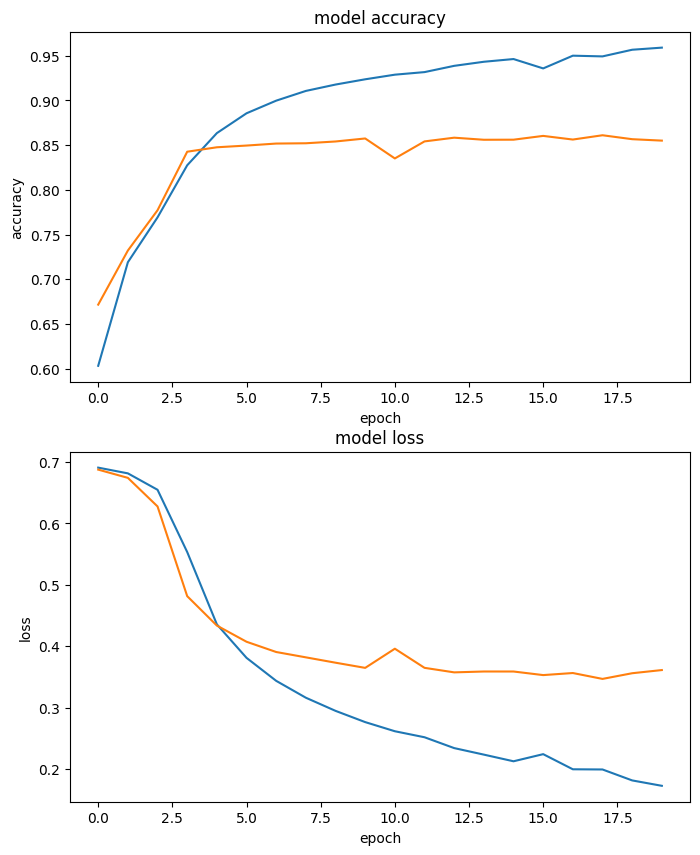

In [ ]:
fig, ax = plt.subplots(2, figsize=(8,10))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')

In [ ]:
pred = ab_model.predict(X_test)
pred = pred.round()
print(classification_report(y_test, pred))

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      6192
         1.0       0.86      0.85      0.86      6308

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



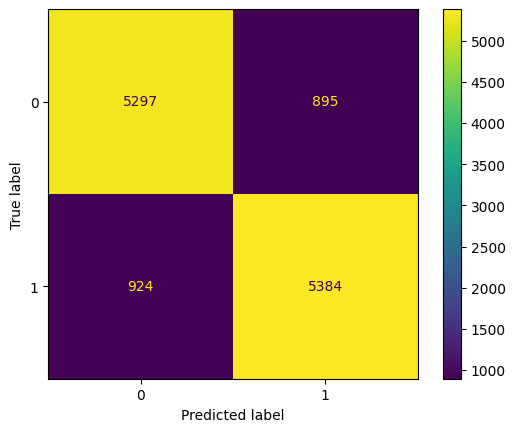

In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print("Overall metrics:\n")
print("Accuracy: %.2f" % (model.evaluate(X_test, y_test)[1]))
print("Precision: %.2f" % (precision_score(y_test, pred)))
print("Recall: %.2f" % (recall_score(y_test, pred)))
print("F1 score: %.2f" % (f1_score(y_test, pred)))

Overall metrics:

391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.8605 - loss: 0.3343
Accuracy: 0.86
Precision: 0.86
Recall: 0.85
F1 score: 0.86
